# Sentence Similarity using BERT

In this notebook we will calculate the similarity of different sentences using BERT. Three sentences will be sent through the BERT model to retrieve its embeddings and use them to calculate the sentence similarity by:

# Import the Libraries

In [59]:
# vizualization library
import matplotlib.pyplot as plt
import numpy as np

# pytorch library
import torch # the main pytorch library
import torch.nn.functional as f # the sub-library containing different functions for manipulating with tensors

# huggingface's transformers library
from transformers import BertModel, BertTokenizer

# Setting the Device

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import BERT Tokenizer and Model

In [61]:
bert_version = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

In [62]:
model = model.eval()

In [63]:
# the .to method allows us to move the model to the provided device
model = model.to(device)

# BERT Tokenizer

We have have the following sentences for which we want to measure their similarities. While the first two sentences are semantically similar, the third sentence could be considered as random.

In [64]:
texts  = [
    'Obama speaks to the media in Illinois',
    'The president greets the press in Chicago',
    'Oranges are my favorite fruit',
]

In [65]:
encodings = tokenizer(
    texts, # the texts to be tokenized
    padding=True, # pad the texts to the maximum length (so that all outputs have the same length)
    return_tensors='pt' # return the tensors (not lists)
)

**The input tensors need to be on the same device as the model.** In order for us to use the BERT model to get the sentence embeddings we must first move the input tensors to the same device as the model.

In [66]:
encodings = encodings.to(device)

The BERT tokenizer returns three values:

- **input_ids.** The list/tensor of token ids for each sentence. The id `101` represents the class token `[CLS]`, `102` represents the separator token `[SEP]`, and `0` represents the padding token `[PAD]`.
- **attention_mask.** This list/tensor represents which ids to use when generating the tokens (e.g. ignores the `[PAD]` tokens).
- **token_type_ids.** This list/tensor represents which tokens correspond to the first and second sentence (used for next sentence prediction).

In [67]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [68]:
encodings['input_ids']

tensor([[  101,  7661,  8917,  1106,  1103,  2394,  1107,  3461,   102,     0],
        [  101,  1109,  2084, 18884,  1116,  1103,  3181,  1107,  2290,   102],
        [  101,  6309,  1116,  1132,  1139,  5095,  5735,   102,     0,     0]])

In [69]:
encodings['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [70]:
encodings['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## WordPiece

The BERT model uses the [WordPiece tokenizer][wordpiece].

Lets convert the ids into tokens and output their representaitons.

[wordpiece]: https://huggingface.co/transformers/v3.5.1/tokenizer_summary.html#wordpiece

In [71]:
for tokens in encodings['input_ids']:
    print(tokenizer.convert_ids_to_tokens(tokens))

['[CLS]', 'Obama', 'speaks', 'to', 'the', 'media', 'in', 'Illinois', '[SEP]', '[PAD]']
['[CLS]', 'The', 'president', 'greet', '##s', 'the', 'press', 'in', 'Chicago', '[SEP]']
['[CLS]', 'Orange', '##s', 'are', 'my', 'favorite', 'fruit', '[SEP]', '[PAD]', '[PAD]']


# Embeddings

In order to get the token embeddings we will send the encodings through the model. Pytorch by default calculates the gradients for every layer of the model which is really handy when training the model but not when we want to use it in production. **Gradients take additional space on CPU or GPU which you don't want to populate with things you don't need.**

We can disable gradient calculation by adding the `with torch.no_grad():` before the model.


In [72]:
# disable gradient calculations
with torch.no_grad():
    # get the model embeddings
    embeds = model(**encodings)

The output of the model is a tuple of tensors:

- The first tensor (`embeds[0]`) contains the embeddings of the sentence tokens.
- The second tensor (`embeds[1]`) contains the embeddings of the `[CLS]` token that can be then sent further to train the next sentence prediction. We won't use this tensor in this notebook.

In [73]:
embeds = embeds[0]

In [74]:
embeds

tensor([[[ 0.0674, -0.6799, -0.0995,  ..., -0.7554, -0.1278, -0.0802],
         [-0.0692, -0.8303,  0.1546,  ...,  0.0585,  0.4058, -0.4544],
         [ 0.3453,  0.4382, -0.1015,  ...,  1.0000,  0.0899, -0.3750],
         ...,
         [-0.3001, -0.2914, -0.4403,  ..., -0.2097,  0.0924,  0.2608],
         [ 0.1587, -0.9241, -0.2980,  ..., -1.0242,  0.0539, -0.5048],
         [-0.1048,  0.2301, -0.4866,  ..., -0.1824, -0.4323, -0.2062]],

        [[-0.0607, -0.6513,  0.0976,  ..., -0.5838, -0.2506, -0.0793],
         [-0.7293, -0.8764,  0.1441,  ..., -0.1109,  0.2422, -0.4569],
         [-0.6750,  0.2065, -0.0833,  ..., -0.2243, -0.4838, -0.5572],
         ...,
         [ 0.7558,  0.8281, -0.1101,  ...,  0.1019,  0.1509, -1.0411],
         [-0.1496,  0.0602, -0.5405,  ..., -0.1064, -0.0799, -0.0631],
         [-0.2964, -0.7394, -0.2699,  ..., -0.6030, -0.0724, -0.8694]],

        [[-0.5826, -0.4716,  0.3686,  ..., -0.3705, -0.7758, -0.1986],
         [-0.5181, -0.6193, -0.2700,  ..., -0

In [75]:
# to get the size of the tensor use .shape (similar as with numpy)
embeds.shape

torch.Size([3, 10, 1024])

# Measure the Sentence Similarities

Now that we got the sentence token embeddings we will calculate the sentence similarities. We will od this in three ways:

- Using the `[CLS]` token embeddings.
- Calculating the mean of all sentence token embeddings.
- Calculating the max-over-time of the sentence token embeddings.

In all three ways we will calculate the sentence similarities using the cosine distance.

In [76]:
def visualize(distances, figsize=(10, 5), titles=None):
    # get the number of columns
    ncols = len(distances)
    # create the subplot placeholders
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    
    for i in range(ncols):
        
        # get the axis in which we will draw the matrix
        axes = ax[i] if ncols > 1 else ax
        
        # get the i-th distance
        distance = distances[i]
        
        # create the heatmap
        axes.imshow(distance)
        
        # show the ticks
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        
        # set the tick labels
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))
        
        # set the values in the heatmap
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)),
                               ha="center", va="center", color="w")
        
        # set the title of the subplot
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
        
    fig.tight_layout()
    plt.show()

# Way 1: Use the [CLS] Embeddings

We will take the first embedding representing the `[CLS]` token of all three sentences and calculate the cosine distance.

In [77]:
CLSs = embeds[:, 0, :]

In [78]:
# normalize the CLS token embeddings
normalized = f.normalize(CLSs, p=2, dim=1)
# calculate the cosine similarity
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.numpy()

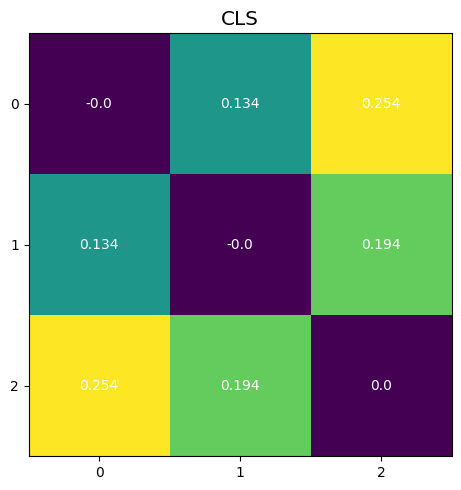

In [79]:
visualize([cls_dist], titles=["CLS"])

# Way 2: Computing the Mean of All Output Vectors

We will calculate the mean of all embeddings for each sentence and calculate the cosine distance. To get the means we will use the `.mean` method that is documented [here][mean].

[mean]: https://pytorch.org/docs/stable/generated/torch.mean.html#torch.mean

In [80]:
MEANS = embeds.mean(dim=1)

In [81]:
# normalize the MEANS token embeddings
normalized = f.normalize(MEANS, p=2, dim=1)
# calculate the cosine similarity
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.numpy()

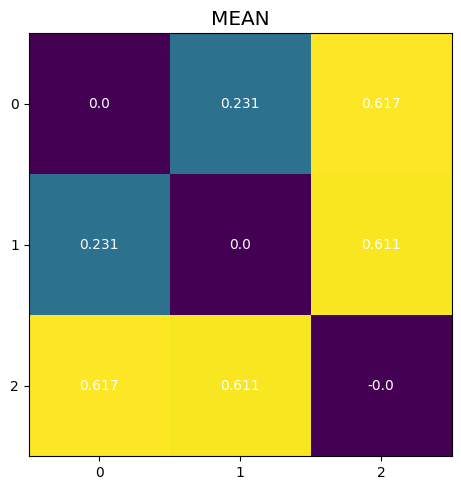

In [82]:
visualize([mean_dist], titles=["MEAN"])

# Way 3: Compute the max-over-time of the Output Vectors

We will calculate the max-over-time of all embeddings for each sentence and calculate the cosine distance. The max-over-time is basically getting the maximum value for each dimension of the tokens. For example, if a sentence has two tokens:

In [83]:
MAXS, _ = embeds.max(dim=1)

In [84]:
# normalize the MEANS token embeddings
normalized = f.normalize(MAXS, p=2, dim=1)
# calculate the cosine similarity
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.numpy()

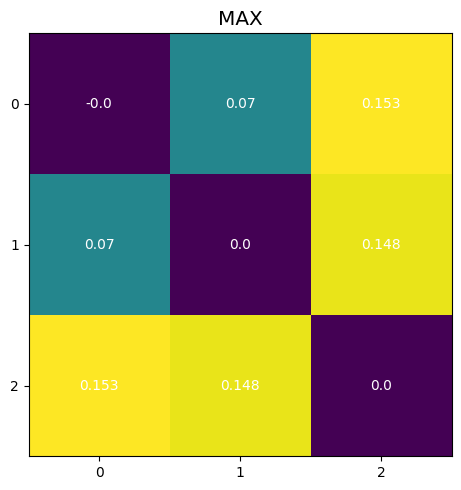

In [85]:
visualize([max_dist], titles=["MAX"])

# Compare the Distances

Now lets visualize all three distances. We see that all three approaches are able to measure the semantic similarity. Which one to take depends on the task that you are interested in.

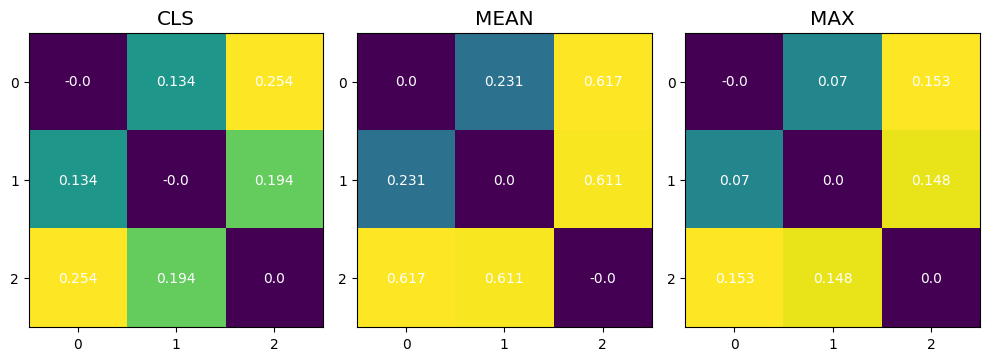

In [86]:
dist = [cls_dist, mean_dist, max_dist]
titles = ["CLS", "MEAN", "MAX"]
visualize(dist, titles=titles)